# README

This takes the data generated from gen_2DWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method. This code is changed from the npWindow experiment in that both windows vary in the central location. We also allow the SNR to vary.

# Libraries

In [21]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Add Curve Analysis

In [22]:
SNR_index_oi = 1

cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

data_file = 'addCurve_DATA'
exp_file = 'addCurveBIC_Exp'
exp_date = '23Jan24'
run_head = 'addC'

add_tag = "standard"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

c:\co\NIA\


In [23]:
with open(f'{cwd_full}{base_file}/{exp_file}/{data_file}/hprParameter_{add_tag}_T2rat_SNRsuite_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    T2rat_array = dict['T2_ratio']
    SNR_array = dict["SNR_array"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21 = true_params

#Uncalculable with the variable T22 value
# R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
# R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

print(f"SNR of interest = {SNR_array[SNR_index_oi]:0.2f}")

SNR of interest = 29.47


### Standard Analysis

In [24]:
SR_folder = 'Comparison_DATA'
SR_date = '04Jan24'
SR_run = 'SNRsuite_T2rat'

In [25]:
with open(f'{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/hprParameter_AIC_{SR_run}_{SR_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SR_SNR_values = dict["SNR_array"]
    SR_T2rat_array = dict["T2_ratio"]
    SR_true_params = dict["true_params"]
    SR_TI_STANDARD = dict["TI_DATA"]
    SR_nTE = dict["nTE"]
    SR_dTE = dict["dTE"]
    SR_var_reps = dict["var_reps"]
    SR_multi_start = dict['multi_start']
    handle.close()

for iter in range(len(true_params)):
    assert(SR_true_params[iter] == true_params[iter])

for iter in range(len(T2rat_array)):
    assert(np.any(SR_T2rat_array, where = T2rat_array[iter]))

for iter in range(len(SNR_array)):
    assert(np.any(SR_SNR_values, where=SNR_array[iter]))

# Functions

In [26]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_T2RAT = np.stack(df["T2_rat"].values) #shape: 
    ALL_SNR = np.stack(df["SNR"].values) #shape: 
    ALL_SNR_eTime = np.stack(df["SNR_eTime"].values) #shape:  
    ALL_MSE = np.stack(df["MSE"].values) #shape: 
    ALL_VAR = np.stack(df["var"].values) #shape: 

    ALL_BIAS = np.stack(df["bias"].values) #shape: 

    ALL_pEst_COFFEE = np.stack(df["pEst_COFFEE"].values) #shape: 
    # ALL_pEst_cvn = np.stack(df["pEst_cf"].values) #shape: 
    ALL_pEst_cf_pre = np.stack(df['pEst_cf_pre'].values) #shape: 
    ALL_pEst_cf_post = np.stack(df['pEst_cf_post'].values) #shape: 
    
    return ALL_T2RAT, ALL_SNR, ALL_SNR_eTime, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_pEst_COFFEE, ALL_pEst_cf_pre, ALL_pEst_cf_post

def to_readable_SR(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: 
    ALL_T2RAT = np.stack(df["T2_rat"].values) #shape: 
    ALL_MSE = np.stack(df["MSE"].values) #shape: 
    ALL_VAR = np.stack(df["var"].values) #shape: 

    ALL_BIAS = np.stack(df["bias"].values) #shape: 

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: 
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: 
    
    return ALL_SNR, ALL_T2RAT, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore, axis=0)
    biMat = np.mean(paramStore, axis = 0) - true_params  #E[p_hat] - p_true
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, varMat, biMat

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [27]:
def prepare_data(p_oi):
    # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    MSE_ordered = np.zeros((len(T2rat_array), len(SNR_array),4))
    var_ordered = np.zeros((len(T2rat_array), len(SNR_array),4))
    bias_ordered = np.zeros((len(T2rat_array), len(SNR_array),4))

    eqSNR_ordered = np.zeros((len(T2rat_array), len(SNR_array)))

    pEst_COFFEE_ordered = np.zeros((len(T2rat_array), len(SNR_array), var_reps, len(ParamTitle_6p)))
    pEst_cf_pre_ordered = np.zeros((len(T2rat_array), len(SNR_array), var_reps, len(ParamTitle_6p)))
    pEst_cf_post_ordered = np.zeros((len(T2rat_array), len(SNR_array), var_reps, len(ParamTitle_6p)))

    data_name = f"{cwd_full}{base_file}/{exp_file}/{data_file}/{run_head}_{add_tag}_T2rat_SNRsuite_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    T2RAT, var_SNR, eqSNR, MSE, VAR, BIAS, pEst_COFFEE, pEst_cf_pre, pEst_cf_post = to_readable_2DWindow(data_name)

    for index in range(len(MSE)):

        temp_T2rat = T2RAT[index]
        temp_SNR = var_SNR[index]

        T2rat_index = np.where(temp_T2rat==T2rat_array)[0][0]
        SNR_index = np.where(temp_SNR==SNR_array)[0][0]

        MSE_ordered[T2rat_index, SNR_index, :] = MSE[index,:,p_oi]
        var_ordered[T2rat_index, SNR_index, :] = VAR[index,:,p_oi]
        bias_ordered[ T2rat_index, SNR_index, :] = BIAS[index,:,p_oi]
        eqSNR_ordered[T2rat_index, SNR_index] = eqSNR[index]
        pEst_COFFEE_ordered[T2rat_index, SNR_index, :, :] = pEst_COFFEE[index,:,:]
        pEst_cf_pre_ordered[T2rat_index, SNR_index, :, :] = pEst_cf_pre[index,:,:]
        pEst_cf_post_ordered[T2rat_index, SNR_index, :, :] = pEst_cf_post[index,:,:]

    return MSE_ordered, var_ordered, bias_ordered, eqSNR_ordered, pEst_COFFEE_ordered, pEst_cf_pre_ordered, pEst_cf_post_ordered

# Data Organization

In [28]:
MSE, var, bias, SNRs, pEst_COFFEE, pEst_cf_pre, pEst_cf_post = prepare_data(param_oi)

SR_name = f"{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/{SR_run}_{SR_date}.pkl"
SR_SNR, SR_T2Rat, SR_MSE, SR_VAR, SR_BIAS, SR_pEst_AIC, SR_pEst_cf = to_readable_SR(SR_name)


Retrieving data for c:\co\NIA\Stabilization/addCurveBIC_Exp/addCurve_DATA/addC_standard_T2rat_SNRsuite_23Jan24.pkl


# Histograms

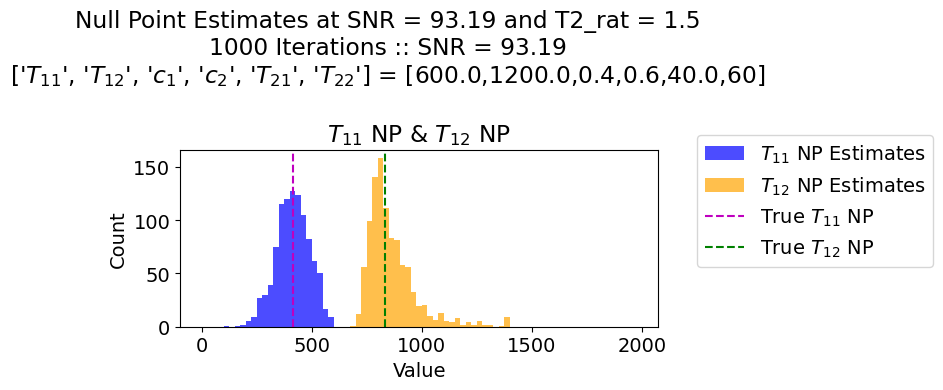

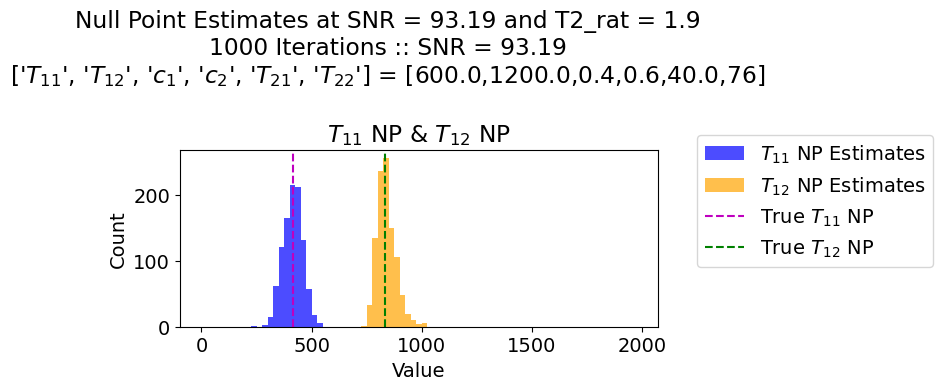

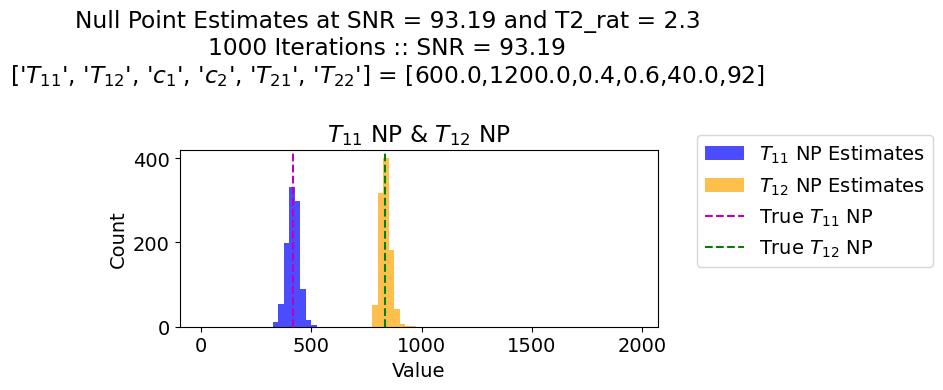

In [37]:
SNR_index_oi = 8

T2rat_oi_list = np.array([0,4,8])
# hist_titles = ["top left", "top right", "bottom right", "bottom left", "center"]

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]

for iter in range(len(T2rat_oi_list)):

    T2_rat_oi = T2rat_oi_list[iter]

    T2rat_true_params = [T11, T12, c1, c2, T21, T2rat_array[T2_rat_oi]*T21]

    mat2 = np.where(T2rat_array[T2_rat_oi] == SR_T2Rat)[0]
    SR_index_match = np.intersect1d(mat1,mat2)[0]

    plt.rc('font', size = 14)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
    fig.suptitle(f"Null Point Estimates at SNR = {SNR_array[SNR_index_oi] :0.2f} and T2_rat = {T2rat_array[T2_rat_oi]:0.1f}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2_rat_oi]:.0f}]")

    bin_array = np.arange(0, 2000, 25)
    ax.hist(x=pEst_cf_pre[T2_rat_oi, SNR_index_oi, :,0]*np.log(2), bins=bin_array, color='b', alpha = 0.7, label = f'{ParamTitle_6p[0]} NP Estimates')
    ax.hist(x=pEst_cf_pre[T2_rat_oi, SNR_index_oi, :,1]*np.log(2), bins=bin_array, color='orange', alpha = 0.7, label = f'{ParamTitle_6p[1]} NP Estimates')
    ax.axvline(x = TI1star, color='m', ls = '--', label = f'True {ParamTitle_6p[0]} NP')
    ax.axvline(x = TI2star, color='g', ls = '--', label = f'True {ParamTitle_6p[1]} NP')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f"{ParamTitle_6p[0]} NP & {ParamTitle_6p[1]} NP")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")


    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Line Plots

In [30]:
SNR_vs_rat_mat = np.zeros((len(SNR_array), len(T2rat_array)))

for iSNR in range(len(SNR_array)):
    for iT2 in range(len(T2rat_array)):

        mat1 = np.where(SNR_array[iSNR] == SR_SNR)[0]
        mat2 = np.where(T2rat_array[iT2] == SR_T2Rat)[0]
        SR_index_match = np.intersect1d(mat1,mat2)[0]

        temp_SR_MSE = SR_MSE[SR_index_match,param_oi]

        temp_MSE_imp = temp_SR_MSE-MSE[iT2, iSNR, 0]

        SNR_vs_rat_mat[iSNR, iT2] = temp_MSE_imp

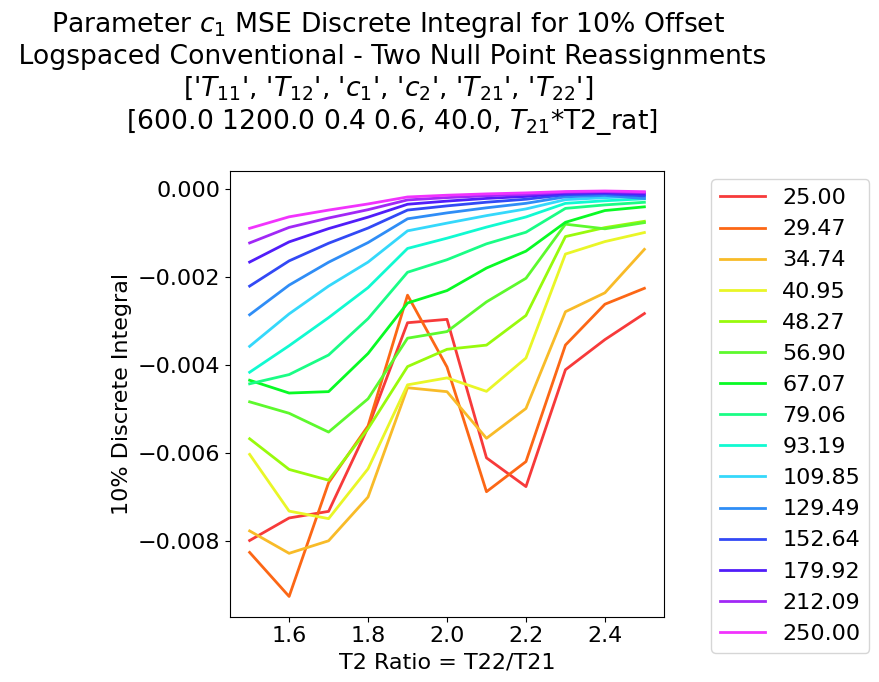

In [31]:
colors_list = _get_colors(len(SNR_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Discrete Integral for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iSNR in range(len(SNR_array)):
    ax.plot(T2rat_array, SNR_vs_rat_mat[iSNR,:], color = colors_list[iSNR], ls = '-', lw = 2, label = f"{SNR_array[iSNR]:.2f}")

ax.set_ylabel("10% Discrete Integral")
ax.set_xlabel("T2 Ratio = T22/T21")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

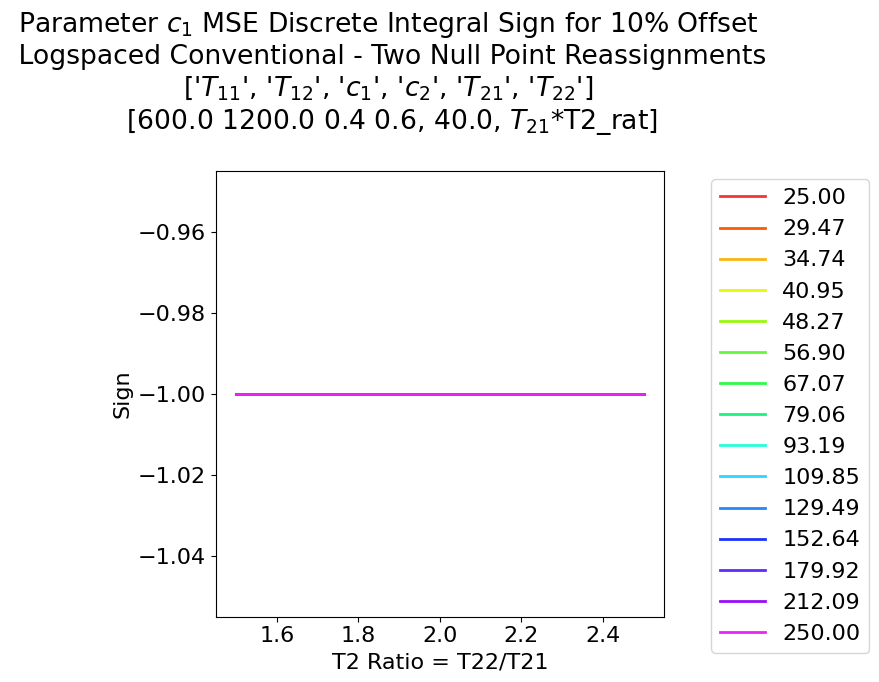

In [32]:
colors_list = _get_colors(len(SNR_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Discrete Integral Sign for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iSNR in range(len(SNR_array)):
    ax.plot(T2rat_array, np.sign(SNR_vs_rat_mat[iSNR,:]), color = colors_list[iSNR], ls = '-', lw = 2, label = f"{SNR_array[iSNR]:.2f}")

ax.set_ylabel("Sign")
ax.set_xlabel("T2 Ratio = T22/T21")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

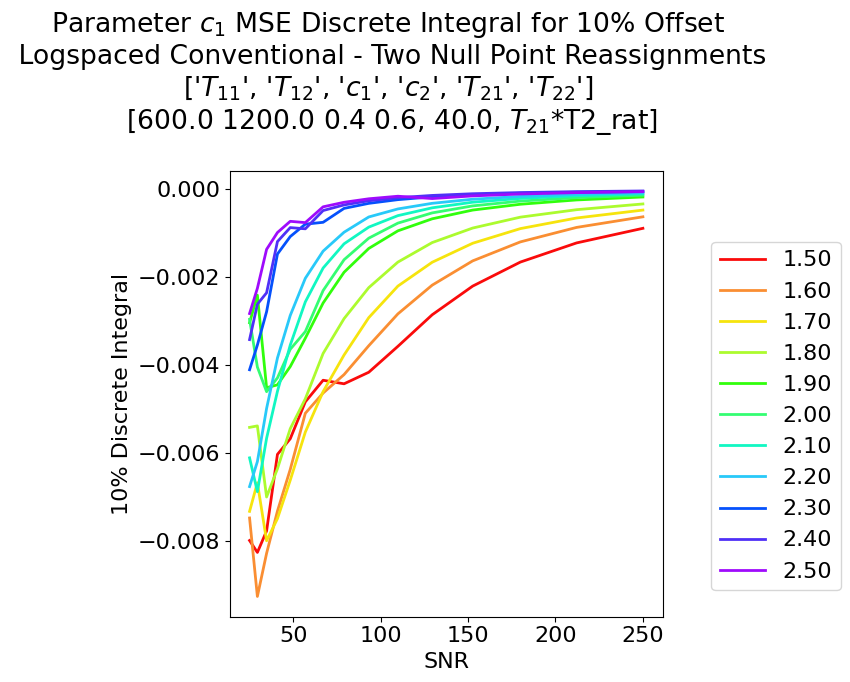

In [33]:
colors_list = _get_colors(len(T2rat_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Discrete Integral for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iT2 in range(len(T2rat_array)):
    ax.plot(SNR_array, SNR_vs_rat_mat[:, iT2], color = colors_list[iT2], ls = '-', lw = 2, label = f"{T2rat_array[iT2]:.2f}")

ax.set_ylabel("10% Discrete Integral")
ax.set_xlabel("SNR")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

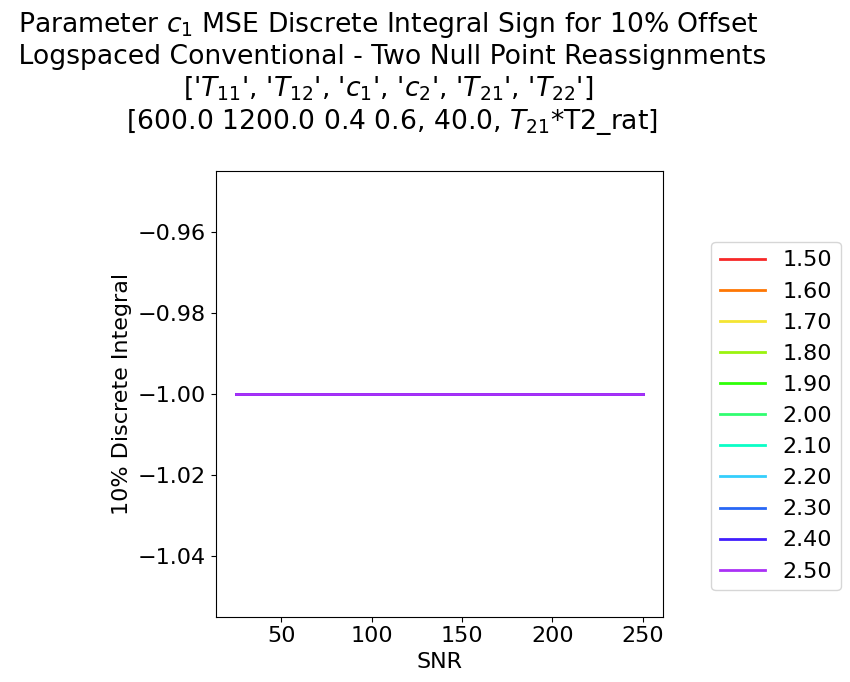

In [34]:
colors_list = _get_colors(len(T2rat_array) + 2)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (6, 7), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Discrete Integral Sign for 10% Offset\n Logspaced Conventional - Two Null Point Reassignments\n{ParamTitle_6p}\n [{T11} {T12} {c1} {c2}, {T21}, {ParamTitle_6p[-2]}*T2_rat]")

for iT2 in range(len(T2rat_array)):
    ax.plot(SNR_array, np.sign(SNR_vs_rat_mat[:, iT2]), color = colors_list[iT2], ls = '-', lw = 2, label = f"{T2rat_array[iT2]:.2f}")

ax.set_ylabel("10% Discrete Integral")
ax.set_xlabel("SNR")
fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

In [35]:
# mat_oi = SNRs

# eqT_map = plt.get_cmap('turbo')
# eqT_map.set_extremes(over = 'blue')
# extend_opt = "max"      #max or none

# plt.rc('font', size = 16)
# fig, ax = plt.subplots(1,1, figsize = (5, 5), tight_layout=True)
# fig.suptitle(f"Equal Time Influence on SNR")

# plt.rc('font', size = 16)
# ax.set_title(f"SNR = {SNR_value}")
# imc1 = ax.imshow(mat_oi, cmap = eqT_map)

# # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
# ax.set_xticks(np.arange(len(np2_array)))
# ax.set_yticks(np.arange(len(np1_array)))

# temp_x_labels = ["" for a in np2_array]
# x_array = [0,len(np2_array)//4,len(np2_array)//2, 3*len(np2_array)//4, -1]
# for elem in x_array:
#     temp_x_labels[elem] = f"{np2_array[elem]:0.1f}"
# ax.set_xticklabels(temp_x_labels)

# temp_y_labels = ["" for a in np1_array]
# y_array = [0,len(np1_array)//4,len(np1_array)//2, 3*len(np1_array)//4, -1]
# for elem in y_array:
#     temp_y_labels[elem] = f"{np1_array[elem]:0.1f}"
# ax.set_yticklabels(temp_y_labels)

# ax.set_ylabel(r'TI$_1^*$ Guess Offset')
# ax.set_xlabel(r'TI$_2^*$ Guess Offset')
# plt.rc('font', size = 12)
# cbar = fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.2, location = 'bottom', extend = extend_opt)#, format = '%.2e')
# # cbar.formatter.set_powerlimits((0,0))

# Example Pixel Histograms

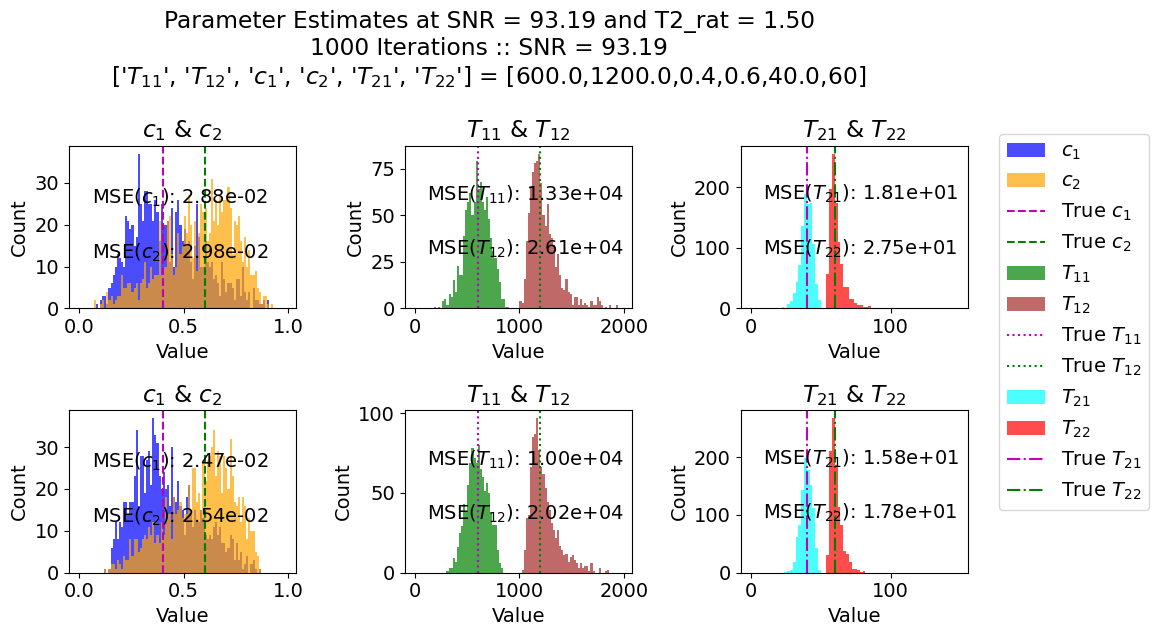

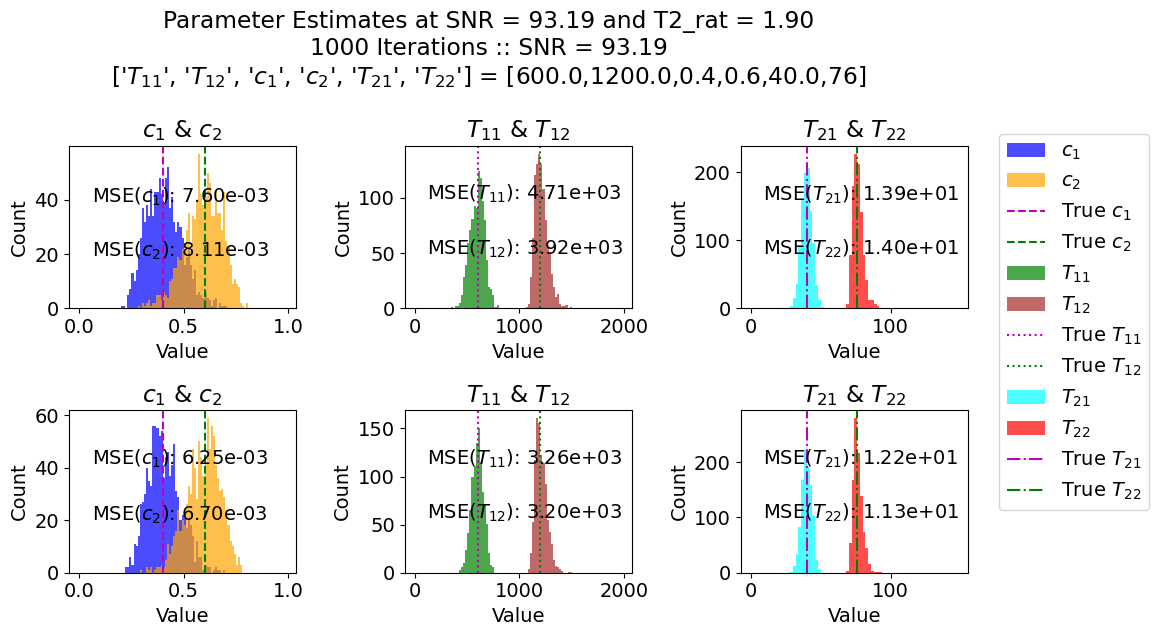

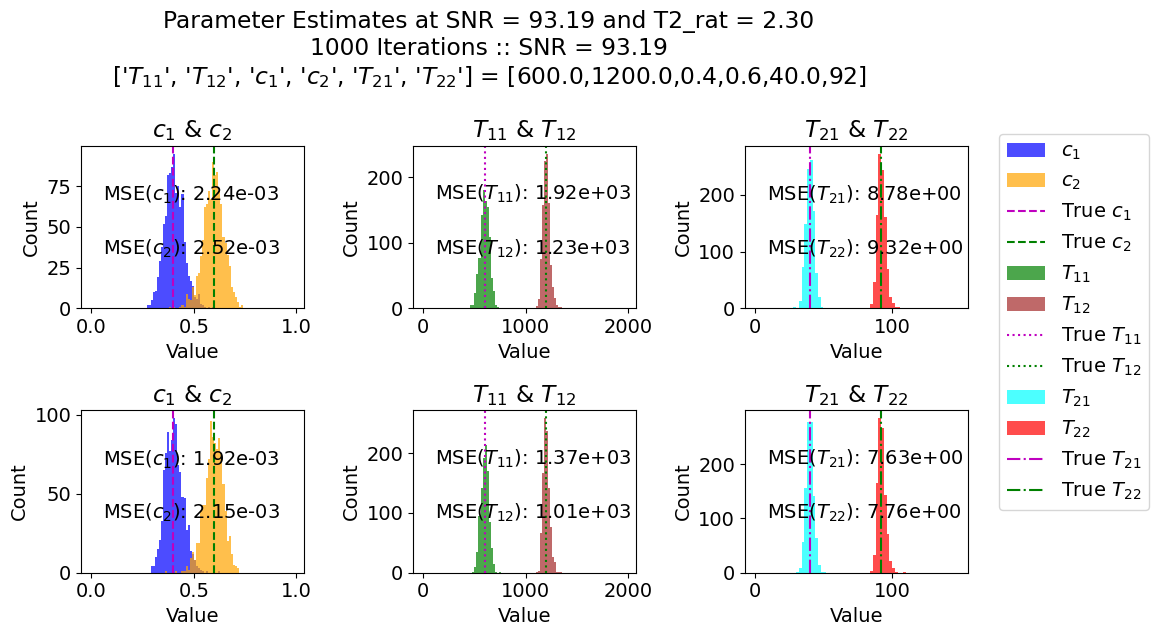

In [36]:
SNR_index_oi = 8

T2rat_oi_list = np.array([0,4,8])
# hist_titles = ["top left", "top right", "bottom right", "bottom left", "center"]

mat1 = np.where(SNR_array[SNR_index_oi] == SR_SNR)[0]

for iter in range(len(T2rat_oi_list)):

    T2_rat_oi = T2rat_oi_list[iter]

    T2rat_true_params = [T11, T12, c1, c2, T21, T2rat_array[T2_rat_oi]*T21]

    mat2 = np.where(T2rat_array[T2_rat_oi] == SR_T2Rat)[0]
    SR_index_match = np.intersect1d(mat1,mat2)[0]

    plt.rc('font', size = 14)

    fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
    fig.suptitle(f"Parameter Estimates at SNR = {SNR_array[SNR_index_oi] :0.2f} and T2_rat = {T2rat_array[T2_rat_oi]:0.2f}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2_rat_oi]:.0f}]")

    pEst_compare = pEst_COFFEE

    MSEMat, varMat, sqBMat = calc_MSE(pEst_compare[T2_rat_oi, SNR_index_oi, :, :], T2rat_true_params)

    bin_array = np.arange(0, 1, 0.01)
    ax[0,0].hist(x=pEst_compare[T2_rat_oi, SNR_index_oi, :,-4], bins=bin_array, color='b', alpha = 0.7)
    ax[0,0].hist(x=pEst_compare[T2_rat_oi, SNR_index_oi,:,-3], bins=bin_array, color='orange', alpha = 0.7)
    ax[0,0].axvline(x = true_params[2], color='m', ls = '--')
    ax[0,0].axvline(x = true_params[3], color='g', ls = '--')
    ax[0,0].set_xlabel('Value')
    ax[0,0].set_ylabel('Count')
    ax[0,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

    ymin, ymax = ax[0,0].get_ylim()
    xmin, xmax = ax[0,0].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    ax[0,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    ax[0,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

    bin_array = np.arange(0, 2000, 20)
    ax[0,1].hist(x=pEst_compare[T2_rat_oi, SNR_index_oi,:,0], bins=bin_array, color='g', alpha = 0.7)
    ax[0,1].hist(x=pEst_compare[T2_rat_oi, SNR_index_oi,:,1], bins=bin_array, color='brown', alpha = 0.7)
    ax[0,1].axvline(x = true_params[0], color='m', ls = ':')
    ax[0,1].axvline(x = true_params[1], color='g', ls = ':')
    ax[0,1].set_xlabel('Value')
    ax[0,1].set_ylabel('Count')
    ax[0,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

    ymin, ymax = ax[0,1].get_ylim()
    xmin, xmax = ax[0,1].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    ax[0,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
    ax[0,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

    bin_array = np.arange(0, 150, 2)
    ax[0,2].hist(x=pEst_compare[T2_rat_oi, SNR_index_oi,:,-2], bins=bin_array, color='cyan', alpha = 0.7)
    ax[0,2].hist(x=pEst_compare[T2_rat_oi, SNR_index_oi,:,-1], bins=bin_array, color='red', alpha = 0.7)
    ax[0,2].axvline(x = true_params[-1], color='m', ls = '-.')
    ax[0,2].axvline(x = T2rat_array[T2_rat_oi]*T21, color='g', ls = '-.')
    ax[0,2].set_xlabel('Value')
    ax[0,2].set_ylabel('Count')
    ax[0,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

    xmin, xmax = ax[0,2].get_xlim()
    ymin, ymax = ax[0,2].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    ax[0,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
    ax[0,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')


    MSEMat, varMat, sqBMat = calc_MSE(SR_pEst_cf[SR_index_match,:,:], T2rat_true_params)

    bin_array = np.arange(0, 1, 0.01)
    ax[1,0].hist(x=SR_pEst_cf[SR_index_match,:,-4], bins=bin_array, color='b', label = r'$c_{1}$', alpha = 0.7)
    ax[1,0].hist(x=SR_pEst_cf[SR_index_match,:,-3], bins=bin_array, color='orange', label = r'$c_{2}$', alpha = 0.7)
    ax[1,0].axvline(x = true_params[2], label = r'True $c_{1}$', color='m', ls = '--')
    ax[1,0].axvline(x = true_params[3], label = r'True $c_{2}$', color='g', ls = '--')
    ax[1,0].set_xlabel('Value')
    ax[1,0].set_ylabel('Count')
    ax[1,0].set_title(f"{ParamTitle_6p[-4]} & {ParamTitle_6p[-3]}")#\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

    xmin, xmax = ax[1,0].get_xlim()
    ymin, ymax = ax[1,0].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

    bin_array = np.arange(0, 2000, 20)
    ax[1,1].hist(x=SR_pEst_cf[SR_index_match,:,0], bins=bin_array, color='g', label = r'$T_{11}$', alpha = 0.7)
    ax[1,1].hist(x=SR_pEst_cf[SR_index_match,:,1], bins=bin_array, color='brown', label = r'$T_{12}$', alpha = 0.7)
    ax[1,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
    ax[1,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
    ax[1,1].set_xlabel('Value')
    ax[1,1].set_ylabel('Count')
    ax[1,1].set_title(f"{ParamTitle_6p[0]} & {ParamTitle_6p[1]}")#\nMSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

    xmin, xmax = ax[1,1].get_xlim()
    ymin, ymax = ax[1,1].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    ax[1,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
    ax[1,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

    bin_array = np.arange(0, 150, 2)
    ax[1,2].hist(x=SR_pEst_cf[SR_index_match,:,-2], bins=bin_array, color='cyan', label = r'$T_{21}$', alpha = 0.7)
    ax[1,2].hist(x=SR_pEst_cf[SR_index_match,:,-1], bins=bin_array, color='red', label = r'$T_{22}$', alpha = 0.7)
    ax[1,2].axvline(x = true_params[-1], label = r'True $T_{21}$', color='m', ls = '-.')
    ax[1,2].axvline(x = T2rat_array[T2_rat_oi]*T21, label = r'True $T_{22}$', color='g', ls = '-.')
    ax[1,2].set_xlabel('Value')
    ax[1,2].set_ylabel('Count')
    ax[1,2].set_title(f"{ParamTitle_6p[-2]} & {ParamTitle_6p[-1]}")#\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

    xmin, xmax = ax[1,2].get_xlim()
    ymin, ymax = ax[1,2].get_ylim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    ax[1,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
    ax[1,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))